# Кластеризация текстов с помощью sklearn

In [22]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn import metrics
import numpy as np
from time import time
from yellowbrick.text import TSNEVisualizer

## Загрузка датасета 20 newsgroups

In [45]:
categories = ['alt.atheism',
            'talk.religion.misc',
            'comp.graphics',
            'sci.space',
             ]
remove = ('headers', 'footers', 'quotes')

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

dataset = fetch_20newsgroups(subset='all', categories=categories,
                                shuffle=True, random_state=42, remove=remove)
labels = dataset.target
true_k = np.unique(labels).shape[0]
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories


## Предобработка текста

In [88]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

def preprocess_text(text):
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stem the words
    porter = PorterStemmer()
    words = [porter.stem(word) for word in words]
    # lemmatize
    # lemmatizer = WordNetLemmatizer()
    # words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [94]:
print("Text preprocessing...")
for i in range(len(dataset.data)):
    dataset.data[i] = preprocess_text(dataset.data[i])
print(f'{i+1} texts were preprocessed')

Text preprocessing...
3387 texts were preprocessed


## Извлечение признаков

In [122]:
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english')
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

done in 0.531991s
n_samples: 3387, n_features: 11878


## Кластеризация

In [123]:
def clustering(algorithm, X, labels):
    print("Clustering sparse data with %s" % algorithm)
    t0 = time()
    algorithm.fit(X)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, algorithm.labels_))
    print("Completeness: %0.3f" % metrics.completeness_score(labels, algorithm.labels_))
    print("V-measure: %0.3f" % metrics.v_measure_score(labels, algorithm.labels_))
    print("Adjusted Rand-Index: %.3f"
          % metrics.adjusted_rand_score(labels, algorithm.labels_))
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, algorithm.labels_, sample_size=1000))
    
    return algorithm

In [124]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
km = clustering(km, X, labels)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 1.954s

Homogeneity: 0.344
Completeness: 0.376
V-measure: 0.359
Adjusted Rand-Index: 0.205
Silhouette Coefficient: 0.007


#### Топ-термы в кластерах

In [125]:
def top_terms(model, true_k, is_lsa):
    print("Top terms per cluster:")
    if is_lsa:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    
    terms = vectorizer.get_feature_names()

    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [126]:
top_terms(km, true_k, False)

Top terms per cluster:
Cluster 0: nt think like post use time know read plea point
Cluster 1: god nt moral christian say peopl believ think jesu religion
Cluster 2: file imag thank graphic program format use know anyon look
Cluster 3: space orbit launch nt mission shuttl moon cost satellit use


#### Визуализация кластеров

In [105]:
def tsne_plot_clusters(model, X, num_of_docs):
    tsne = TSNEVisualizer()
    tsne.fit(X[:num_of_docs], ["c{}".format(c) for c in model.labels_[:num_of_docs]])
    tsne.poof()

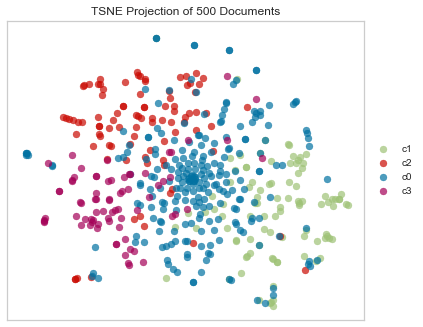

In [127]:
tsne_plot_clusters(km, X, 500)

## Латентно-семантический анализ

In [129]:
print("Performing dimensionality reduction using LSA")
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_lsa = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 0.102361s
Explained variance of the SVD step: 1%


In [130]:
km_lsa = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
km_lsa = clustering(km_lsa, X_lsa, labels)

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=4, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
done in 0.015s

Homogeneity: 0.330
Completeness: 0.332
V-measure: 0.331
Adjusted Rand-Index: 0.293
Silhouette Coefficient: 0.516


In [131]:
top_terms(km_lsa, true_k, True)

Top terms per cluster:
Cluster 0: nt imag file use program know thank graphic like format
Cluster 1: nt god peopl think say believ christian moral jesu exist
Cluster 2: imag file program thank format graphic use know plea look
Cluster 3: nt god think peopl know use like say believ imag


## Агломеративная кластеризация

In [134]:
agc = AgglomerativeClustering(n_clusters=true_k)
agc = clustering(agc, X.toarray(), labels)


Clustering sparse data with AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x107a5b1e0>)
done in 89.139s

Homogeneity: 0.228
Completeness: 0.349
V-measure: 0.276
Adjusted Rand-Index: 0.165
Silhouette Coefficient: 0.007


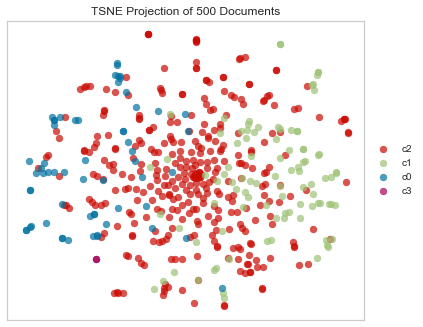

In [135]:
tsne_plot_clusters(agc, X, 500)